In [ ]:
pip install causalgraphicalmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

from causalgraphicalmodels import StructuralCausalModel
from causalgraphicalmodels.csm import discrete_model, linear_model

from sklearn.linear_model import LinearRegression

# Exercise 1:

Implement the following bounds:
1. No assumption bound
2. Monotone treatment response (MTR)
    1. nonnegative: $Y(1) \geq Y(0)$
    2. nonpositive: $Y(1) \leq Y(0)$
3. Monotone treatment selection (MTS): 
$E[Y(1) | T=1] \geq E[Y(1) | T=0]$ and 
$E[Y(0) | T=1] \geq E[Y(0) | T=0]$
4. Optimal treatment selection (OTS): 
$T_i=1 \rightarrow Y_i(1) \geq Y_i(0)$ and
$T_i=0 \rightarrow Y_i(1) < Y_i(0)$
    1. variant 1
    2. variant 2

as functions of the following parameters:
1. $a = min(Y)$
2. $b = max(Y)$
3. $\pi = P(T = 1)$
4. $E[Y | T = 1]$, $E[Y | T = 0]$

Check if you get the expected results for the following values of the input parameters:
$a=0$, $b=1$, $\pi=.3$, $E[Y | T = 1] = .9$, $E[Y | T = 0] = .2$.

Your solution:

*No assumption bound:

In [ ]:
def NAB(pi,a,b,E1,E0):
  upper_bound = (pi* E1) + ((1-pi)*b) - (pi*a) - ((1-pi)*E0)
  lower_bound = (pi* E1) + ((1-pi)*a) - (pi*b) - ((1-pi)*E0)
  return (lower_bound,upper_bound)

In [ ]:
print("The NAB interval is:{}".format(NAB(0.3,0,1,0.9,0.2)))

The NAB interval is:(-0.16999999999999996, 0.83)


*Monotone treatment response (MTR):

In [ ]:
#non-negative
def MTR_nn(pi,a,b,E1,E0):
  upper_bound = (pi* E1) + ((1-pi)*b) - (pi*a) - ((1-pi)*E0)
  lower_bound =0
  return(lower_bound,upper_bound)

#non-positive
def MTR_np(pi,a,b,E1,E0):
  upper_bound = 0
  lower_bound = (pi* E1) + ((1-pi)*a) - (pi*b) - ((1-pi)*E0)
  return(lower_bound,upper_bound)

In [ ]:
print("The non_negative MTR interval is:{}".format(MTR_nn(0.3,0,1,0.9,0.2)))
print("The non_positive MTR interval is:{}".format(MTR_np(0.3,0,1,0.9,0.2)))

The non_negative MTR interval is:(0, 0.83)
The non_positive MTR interval is:(-0.16999999999999996, 0)


*Monotone treatment selection (MTS):

In [ ]:
#MTS
def MTS(pi,a,b,E1,E0):
  upper_bound = E1 - E0
  lower_bound = (pi* E1) + ((1-pi)*a) - (pi*b) - ((1-pi)*E0)
  return(lower_bound,upper_bound)

#MTS+MTR
def MTS_MTR(pi,a,b,E1,E0):
  upper_bound = E1 - E0
  lower_bound = 0
  return(lower_bound,upper_bound)  

In [ ]:
print("The MTS interval is:{}".format(MTS(0.3,0,1,0.9,0.2)))
print("The MTS + MTR interval is:{}".format(MTS_MTR(0.3,0,1,0.9,0.2)))

The MTS interval is:(-0.16999999999999996, 0.7)
The MTS + MTR interval is:(0, 0.7)


Optimal treatment selection (OTS):

In [ ]:
#OTS1
def OTS1(pi,a,b,E1,E0):
  upper_bound = (pi*E1) - (pi*a)
  lower_bound = ((1-pi)*a) - ((1-pi)*E0)
  return(lower_bound,upper_bound)
#OTS2
def OTS2(pi,a,b,E1,E0):
  upper_bound = E1 - (pi*a) - ((1-pi)*E0)
  lower_bound = (pi*E1) + ((1-pi)*a) - E0
  return(lower_bound,upper_bound)

In [ ]:
print("The OTS1 interval is:{}".format(OTS1(0.3,0,1,0.9,0.2)))
print("The OTS2 interval is:{}".format(OTS2(0.3,0,1,0.9,0.2)))

The OTS1 interval is:(-0.13999999999999999, 0.27)
The OTS2 interval is:(0.07, 0.76)


# A Discrete model


True_ATE = 0.389394


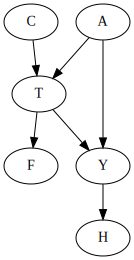

In [ ]:
fd_disc = StructuralCausalModel({
    "C": lambda n_samples: np.random.binomial(n=1, p=0.7, size=n_samples),
    "A": lambda n_samples: np.random.binomial(n=1, p=0.3, size=n_samples),
    "T": discrete_model(["C", "A"], {
        (0, 0): (0.1, 0.9), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.3, 0.7),
        (1, 1): (0.8, 0.2),
        }),  
    "F": discrete_model(["T"], {
        (0, ): (0.6, 0.4),
        (1, ): (0.1, 0.9),
        }),
    "Y": discrete_model(["A", "T"], {
        (0, 0): (0.9, 0.1), 
        (0, 1): (0.3, 0.7),
        (1, 0): (0.4, 0.6),
        (1, 1): (0.5, 0.5),
        }),
    "H": discrete_model(["Y"], {
        (0, ): (0.2, 0.4, 0.4),
        (1, ): (0.8, 0.1, 0.1),
        }),
})
# sampling
data_df = fd_disc.sample(n_samples = 1000000)

# calculation true ATE
set_variable_X = np.array([0]*500000 + [1]*500000)
ab_test_df = fd_disc.do('T').sample(
                    set_values={'T': set_variable_X}, 
                    n_samples=len(set_variable_X),
                  )
true_ate = ab_test_df[ab_test_df['T'] == 1]['Y'].mean() - ab_test_df[ab_test_df['T'] == 0]['Y'].mean()
print('True_ATE = {}'.format(true_ate))

fd_disc.cgm.draw()

## Exercise 2:

Calculate all bounds for the discrete model defined above and check if the true causel effect is within these bounds:

In [ ]:
a = data_df["Y"].min()
b = data_df["Y"].max()
pi = len(data_df[data_df["T"] == 1]) / len(data_df)
e1 = data_df[data_df['T'] == 1]['Y'].mean()
e0 = data_df[data_df['T'] == 0]['Y'].mean()

In [ ]:
pi

0.600995

In [ ]:
print("The NAB interval for this model is:{}".format(NAB(pi,a,b,e1,e0)))
print("The non_negative MTR interval for this model is:{}".format(MTR_nn(pi,a,b,e1,e0)))
print("The non_positive MTR interval for this model is:{}".format(MTR_np(pi,a,b,e1,e0)))
print("The MTS interval for this model is:{}".format(MTS(pi,a,b,e1,e0)))
print("The MTS + MTR interval for this model is:{}".format(MTS_MTR(pi,a,b,e1,e0)))
print("The OTS1 interval for this model is:{}".format(OTS1(pi,a,b,e1,e0)))
print("The OTS2 interval for this model is is:{}".format(OTS2(pi,a,b,e1,e0)))

The NAB interval for this model is:(-0.34956600000000004, 0.650434)
The non_negative MTR interval for this model is:(0, 0.650434)
The non_positive MTR interval for this model is:(-0.34956600000000004, 0)
The MTS interval for this model is:(-0.34956600000000004, 0.28721774028358227)
The MTS + MTR interval for this model is:(0, 0.28721774028358227)
The OTS1 interval for this model is:(-0.15568400000000002, 0.40711299999999995)
The OTS2 interval for this model is is:(0.01693242582173149, 0.5217143144618507)


### MTS: 
$E[Y(1) | T=1] \geq E[Y(1) | T=0]$ and 
$E[Y(0) | T=1] \geq E[Y(0) | T=0]$

What is the intuition behind this assumption? How can we change the model to satisfy the assumption?

What about the following modification?

<code>
"T": discrete_model(["C", "A"], { <br>
        (0, 0): (0.7, 0.3), <br>
        (0, 1): (0.1, 0.9), <br>
        (1, 0): (0.8, 0.2), <br>
        (1, 1): (0.3, 0.7), <br>
        }),
</code>

**Answer** The intuition is that the treatment group's potential outcomes are better than the control groups. It means that in the model the probability of T = 1 is always bigger than the probability of T = 0

So it can be modified like this:

    "T": discrete_model(["C", "A"], {
        (0, 0): (0.3, 0.7), 
        (0, 1): (0.1, 0.9),
        (1, 0): (0.3, 0.7),
        (1, 1): (0.2, 0.8),
        }), 


*In the modification mentioned in the question, I think this does not happen and in 2 cases the probability of T=0 is bigger than T=1.

### OTS:
$T_i=1 \rightarrow Y_i(1) \geq Y_i(0)$ and
$T_i=0 \rightarrow Y_i(1) < Y_i(0)$

What is the intuition behind this assumption? How can we change the model to satisfy the assumption?

What about the following modification?

<code>
"Y": discrete_model(["A", "T"], { <br>
        (0, 0): (0.4, 0.6), <br>
        (0, 1): (0.7, 0.3), <br>
        (1, 0): (0.9, 0.1), <br>
        (1, 1): (0.1, 0.9), <br>
        }),
</code>

**Answer** The intuition behind this assumption is that each individual gets the treatment which is best for them. So the probability of Y=1 should be bigger when T=1, and Y=0 should be bigger when T=0.

So it can be modified like this:

    "Y": discrete_model(["A", "T"], {
        (0, 0): (0.9, 0.1), 
        (0, 1): (0.3, 0.7),
        (1, 0): (0.6, 0.4),
        (1, 1): (0.4, 0.6),
        }),

*In the modifiction mentioned in the question it is not the case, because the probability of Y=0 is lower than Y=1 when T=0 in (0.4,0.6), and the probability of Y=1 is lower than Y=0 when T=1 in (0.7,0.3).

# Excercise 3

Start with the following model and adjust it such that OTS allows identifyng the sign of the causal effect.

Remember the logic behind each assumption.

True_ATE = 0.24889999999999995


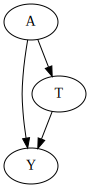

In [ ]:
fd_disc = StructuralCausalModel({
    "A": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "T": discrete_model(["A"], {
        (0,): (0.6, 0.4),
        (1,): (0.4, 0.6),
        }), 
    "Y": discrete_model(["A", "T"], {
        (0, 0): (0.4, 0.6), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.9, 0.1),
        (1, 1): (0.1, 0.9),
        }),
})
# sampling
data_df = fd_disc.sample(n_samples = 1000000)

# calculation true ATE
set_variable_X = np.array([0]*500000 + [1]*500000)
ab_test_df = fd_disc.do('T').sample(
                    set_values={'T': set_variable_X}, 
                    n_samples=len(set_variable_X),
                  )
true_ate = ab_test_df[ab_test_df['T'] == 1]['Y'].mean() - ab_test_df[ab_test_df['T'] == 0]['Y'].mean()
print('True_ATE = {}'.format(true_ate))

fd_disc.cgm.draw()

Your solution

In [ ]:
a1 = data_df["Y"].min()
b1 = data_df["Y"].max()
pi1 = len(data_df[data_df["T"] == 1]) / len(data_df)
e1_1 = data_df[data_df['T'] == 1]['Y'].mean()
e1_0 = data_df[data_df['T'] == 0]['Y'].mean()

In [ ]:
print("The OTS2 interval for this model is is:{}".format(OTS2(pi1,a1,b1,e1_1,e1_0)))

The OTS2 interval for this model is is:(-0.06951370433412707, 0.46074502519172394)


**Answer** Here we can see that OTS2 which allows identifying the sign of the causal effect does not work because the interval ranges from - to +. It is because the model does not satisfy the assumptions of the OTS2.

In this model:

    "Y": discrete_model(["A", "T"], {
        (0, 0): (0.4, 0.6), 
        (0, 1): (0.7, 0.3),
        (1, 0): (0.9, 0.1),
        (1, 1): (0.1, 0.9),
        }),

when T=0 the probability of Y=0 must be higher and when T=1 the probability of Y=1 should be higher, which is not the case here. It can be modified like below:

    "Y": discrete_model(["A", "T"], {
        (0, 0): (0.6, 0.4), 
        (0, 1): (0.3, 0.7),
        (1, 0): (0.9, 0.1),
        (1, 1): (0.1, 0.9),
        }),


True_ATE = 0.5501360000000001


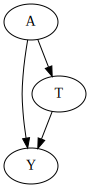

In [ ]:
fd_disc = StructuralCausalModel({
    "A": lambda n_samples: np.random.binomial(n=1, p=0.5, size=n_samples),
    "T": discrete_model(["A"], {
        (0,): (0.6, 0.4),
        (1,): (0.4, 0.6),
        }), 
    "Y": discrete_model(["A", "T"], {
        (0, 0): (0.6, 0.4), 
        (0, 1): (0.3, 0.7),
        (1, 0): (0.9, 0.1),
        (1, 1): (0.1, 0.9),
        }),

})
# sampling
data_df = fd_disc.sample(n_samples = 1000000)

# calculation true ATE
set_variable_X = np.array([0]*500000 + [1]*500000)
ab_test_df = fd_disc.do('T').sample(
                    set_values={'T': set_variable_X}, 
                    n_samples=len(set_variable_X),
                  )
true_ate = ab_test_df[ab_test_df['T'] == 1]['Y'].mean() - ab_test_df[ab_test_df['T'] == 0]['Y'].mean()
print('True_ATE = {}'.format(true_ate))

fd_disc.cgm.draw()

In [ ]:
a2 = data_df["Y"].min()
b2 = data_df["Y"].max()
pi2 = len(data_df[data_df["T"] == 1]) / len(data_df)
e2_1 = data_df[data_df['T'] == 1]['Y'].mean()
e2_0 = data_df[data_df['T'] == 0]['Y'].mean()

In [ ]:
print("The OTS2 interval for this model is is:{}".format(OTS2(pi2,a2,b2,e2_1,e2_0)))

The OTS2 interval for this model is is:(0.1291885391432379, 0.6798069690313772)


Here OTS2 allows identifying the sign of the causal effect.